In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy

flopy is installed in D:\Programme\Anaconda\lib\site-packages\flopy


In [2]:
#Domain

Lx = 2500
Ly = 2
ztop = 0
zbot = -1
ncol = 250
nrow = 10
nlay = 1
delx = Lx/ncol
dely = Ly/nrow
delv = (ztop-zbot)/nlay

In [3]:
#Parameter

prsity = 0.3
al = 5.
trpt = 0.002
Gamma = 3.5
Cd = 5.
Ca = -8.
h1 = 10.
h2 = 0
hk = 86.4
perlen = 1825

In [4]:
#Flow Calculation

mf = flopy.modflow.Modflow(modelname='T02_mf')
dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, delr=delx, delc=dely,top=0, botm=[0-delv], perlen=perlen)

ibound=np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:,:,0] = -1
ibound[:,:,-1] = -1
strt=np.ones((nlay, nrow, ncol), dtype=np.float32)
strt[:,:,0] = h1
strt[:,:,-1] = h2

bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=0)
gmg = flopy.modflow.ModflowGmg(mf)
lmt = flopy.modflow.ModflowLmt(mf)
    
mf.write_input()
mf.run_model(silent=True)

(True, [])

In [5]:
#Transport Calculation

mt = flopy.mt3d.Mt3dms(modelname='T02_mt', exe_name='mt3dms5b', modflowmodel=mf)

icbund = np.ones((nlay, nrow, ncol), dtype=np.int32)
icbund[:,:,0] = -1           #first column
icbund[:,:,-1] = -1          #last column
icbund[:,0,:] = -1           #first row
icbund[:,0,0] = -1           #first cell
sconc = np.zeros((nlay, nrow,ncol), dtype=np.float32)
sconc[:,:,0] = (Gamma*Cd)+2*abs(Ca)
sconc[:,:,-1] = Ca+2*abs(Ca)
sconc[:,0,:] = Ca+2*abs(Ca)
sconc[:,0,0] = 2*abs(Ca)

btn = flopy.mt3d.Mt3dBtn(mt, icbund=icbund, prsity=prsity, sconc=sconc)
adv = flopy.mt3d.Mt3dAdv(mt, mixelm=-1)
dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt)
gcg = flopy.mt3d.Mt3dGcg(mt)
ssm = flopy.mt3d.Mt3dSsm(mt)

mt.write_input()
mt.run_model(silent=True)

(False, [])

In [6]:
ucnobj = flopy.utils.UcnFile('MT3D001.UCN')
conc = ucnobj.get_alldata()
mvt = mt.load_mas('MT3D001.MAS')

Text(0.5, 1.0, 'ULTIMATE')

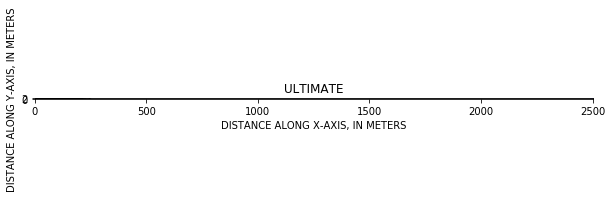

In [7]:
#Plot

plt.figure(figsize=(10,10))
mm = flopy.plot.map.PlotMapView(model=mf)
mm.plot_grid(color='.5', alpha=0.2)
conc = conc[0, :, :]       
cs = mm.contour_array(conc, levels=[16.], colors='k')
mm.plot_ibound()
plt.clabel(cs)
plt.xlabel('DISTANCE ALONG X-AXIS, IN METERS')
plt.ylabel('DISTANCE ALONG Y-AXIS, IN METERS')
plt.title('ULTIMATE')

In [8]:
#Plume length

p1 = cs.collections[0].get_paths()[0]
coor_p1 = p1.vertices
coor_p1[:,0]
np.max(coor_p1[:,0])

220.34085366358602